In [21]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib 
%matplotlib inline 

In [22]:
class LogisticModel():
    
    def __init__(self, dataset, feature_dim, model_name, output_dim = 1, learning_rate = 0.04):
        self.w = np.random.normal(loc = 0, scale = 0.9, size = (feature_dim, output_dim))
        self.b = np.zeros((output_dim,1))
        #print(self.b)
        #print(self.w)
        self.beta = np.concatenate((self.w.transpose(), self.b), axis = 1)
        self.lr = learning_rate
        self.dataset = dataset
        self.model_name = model_name
        #print(dataset)
        np.random.shuffle(self.dataset)
        self.validationset, self.trainset = np.split(self.dataset,[int(self.dataset.shape[0]/3)-31],axis = 0)
        #print("------")
        #print(self.beta)

    def logistic(self,z):
        return 1/(1 + math.exp(-z))

    def forward(self, x):
        # work as prediction process, actually not used in training
        x = x.transpose()
        x = np.expand_dims(x, axis = 1)
        x_hat = np.concatenate((x, np.ones((1, 1))), axis = 0)
        z = np.matmul(self.beta,x_hat)
        return self.logistic(z)

    def predict(self, x):
        logistic = self.forward(x)
        if (logistic) > (1 - logistic):
            return 1
        else:
            return 0

    def loss(self, dset):#要求传入dset，因为有可能有train 与 validation两种loss
        total_loss = 0
        data_x, data_y = np.split(dset,[dset.shape[1]-1],axis = 1)
        for i in range(0, dset.shape[0], 1):
            x = data_x[i]
            y = data_y[i]
            x = x.transpose()
            x = np.expand_dims(x, axis = 1)
            x_hat = np.concatenate((x, np.ones((1, 1))), axis = 0)
            #print("current total loss is ", total_loss)
            total_loss = total_loss + (-y) * np.matmul(self.beta, x_hat) + math.log(1 + math.exp(np.matmul(self.beta, x_hat)))
        return total_loss

    def Gradient_decent(self, batchsize):
        gradient = 0.0
        data_x, data_y = np.split(self.trainset,[self.trainset.shape[1]-1],axis = 1)
        for j in range(0, batchsize, 1):
            x = data_x[j]
            y = data_y[j]
            x = x.transpose()
            #print("x.shape is ", x.shape)
            x = np.expand_dims(x, axis = 1)
            #print("x.shape is ", x.shape)
            x_hat = np.concatenate((x, np.ones((1, 1))), axis = 0)#这里的问题在于取出x的一行，x只有一个维度
            gradient = gradient + (-1) * x_hat * (y - (math.exp(np.matmul(self.beta,x_hat)))/(1 + math.exp(np.matmul(self.beta,x_hat))))
        return gradient

    def train(self, batchsize = 6, epoch = 500):
        TrainLoss = np.zeros((epoch))
        #ValidationLoss = np.zeros((1, epoch))
        currentLoss = 0
        for i in range(0, epoch, 1):
            #print("-----------")
            #print("round = ", i)
            np.random.shuffle(self.trainset)# 检查这里是否改变了self.dataset,还是需要temp = np.random.shuffle(self.dataset)
            self.beta = self.beta - (self.Gradient_decent(batchsize) * self.lr).transpose()
            #print(self.beta)
            currentLoss = self.loss(self.trainset)
            #print("current loss is ", currentLoss)
            TrainLoss[i] = currentLoss
            #ValidationLoss[:, i] = self.validation()
        #print(currentLoss) 
        self.display(TrainLoss)
    
    def validation(self):
        validationloss = self.loss(self.validationset)
        #print("the validation loss is ", validationloss)
        return validationloss

    def display(self, TrainLoss):
        epoch = TrainLoss.shape[0]
        epoch = np.arange(epoch)
        #epoch = np.expand_dims(epoch, axis = 0)
        plt.figure()
        plt.xlabel("epoch")
        plt.ylabel("loss")
        
        plt.plot(epoch, TrainLoss, color = 'r')
        plt.title(self.model_name)
        #plt.plot(epoch, ValidationLoss, label = "Validation")
        #plt.legend()

In [23]:
def ovo(dataset):
    #首先拆分为train 与 validation，然后将train拆分为3个训练集
    dataset_01, temp = np.split(dataset,[100],axis = 0)
    temp, dataset_12 = np.split(dataset,[50],axis = 0)
    dataset0, temp, dataset2 = np.split(dataset,[50,100],axis = 0)
    dataset_02 = np.concatenate((dataset0, dataset2), axis = 0)
    """
    注意,只要改变dataset,都要十分小心,因为拆分出来的dataset都是浅拷贝
    """
    dataset_01 = dataset_01.copy()
    dataset_02 = dataset_02.copy()
    dataset_12 = dataset_12.copy()
    #print("dataset_12 = ",dataset_12)
    #在dataset_12中把 1的标签变为0，2的标签变为1
    for i in range(dataset_12.shape[0]):
        if(dataset_12[i,dataset_12.shape[1]-1] == 1):
            dataset_12[i,dataset_12.shape[1]-1] = 0
        else:
            dataset_12[i,dataset_12.shape[1]-1] = 1

    #在dataset_02中把 2的标签变为1
    for i in range(dataset_02.shape[0]):
        if(dataset_02[i,dataset_02.shape[1]-1] == 2):
            dataset_02[i,dataset_02.shape[1]-1] = 1
    #print(dataset_12)
    #print("----------")
    #print(dataset_02)

    model_01 = LogisticModel(dataset_01, 4, "model_01")
    model_02 = LogisticModel(dataset_02, 4, "model_02")
    model_12 = LogisticModel(dataset_12, 4, "model_12")
    model_01.train()
    model_02.train()
    model_12.train()
    data_x, data_y = np.split(dataset,[dataset.shape[1]-1],axis = 1)
    #print(dataset.shape)
    #print(dataset)
    correct = 0
    wrong = 0
    for i in range(dataset.shape[0]):
        count0 = 0
        count1 = 0
        count2 = 0
        x = data_x[i,:]
        vote_01 = model_01.predict(x)
        if vote_01 == 0:
            count0 = count0 + 1
        else:
            count1 = count1 + 1
        
        vote_02 = model_02.predict(x)
        if vote_02 == 0:
            count0 = count0 + 1
        else:
            count2 = count2 + 1

        vote_12 = model_12.predict(x)
        if vote_12 == 0:
            count1 = count1 + 1
        else:
            count2 = count2 + 1
        
        if(count0 == 2):
            ypredict = 0
        else:
            if(count1 == 2):
                ypredict = 1
            else: 
                if(count2 == 2):
                    ypredict = 2
                else:
                    ypredict = 3
        if(ypredict == int(data_y[i,:])):
            correct = correct + 1
        else: wrong = wrong + 1
        """
        print("number: ", i)
        print("the true label is ", data_y[i,:])
        print("votes01 02 12 are", vote_01, vote_02, vote_12)
        print("predict answer is ", ypredict)
        print("current correct is : ", correct)
        print("current wrong is ", wrong)
        print("---------------")
        test"""

    rate = correct/(correct + wrong)
    print("rate is ", rate)

In [24]:
def main():
    #dataset = pd.read_csv('/home/cyberimpart/cyf/ML_by_hand/iris.csv')
    dataset = pd.read_csv('iris.csv')
    dataset = np.array(dataset.values)
    ovo(dataset)
    #print(dataset)
    #model = LogisticModel(dataset, 4)
    #model.train()
    #print(model.beta)
    #model.validation()

rate is  0.9066666666666666


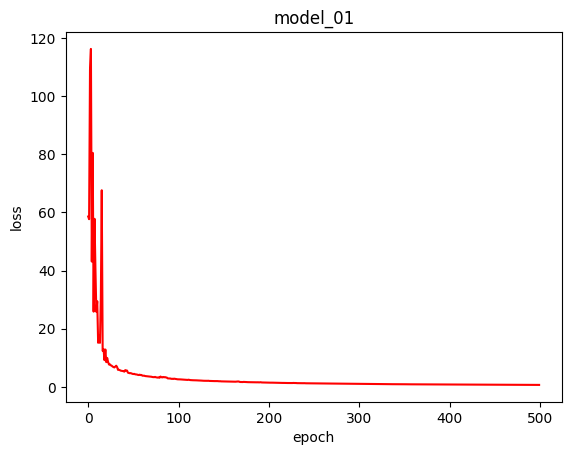

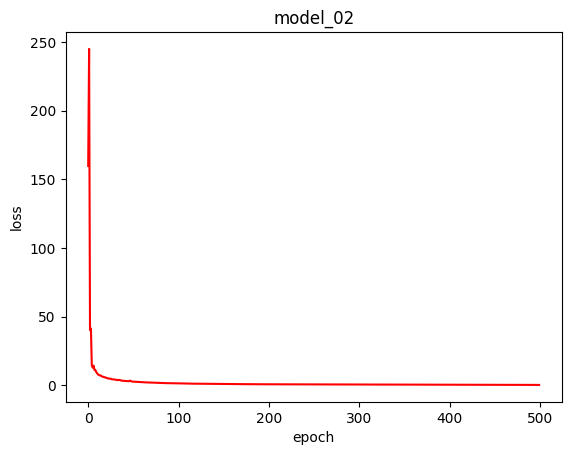

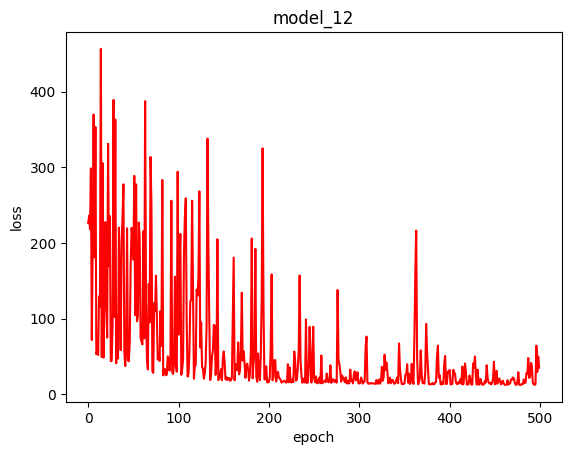

In [25]:
main()